# Implementation of "Fair Decisions Despite Imperfect Predictions" using the original fairness constraint

In [24]:
import numpy as np
from src.consequential_learning import collect_data, train
from src.feature_map import IdentityFeatureMap

## The parameters used by the the original authors  
Note: Learning rate decay is not yet implemented

In [29]:
training_parameters = {
    'dim_x': 1,
    'dim_s': 1,
    'time_steps':200,
    'batch_size':512,
    'num_iterations': 32,
    'learning_parameters': {
        'learning_rate': 0.5,
        'decay_rate': 0.8,
        'decay_step': 30
    },
    'fairness_rate':0,
    'cost_factor':0.55,
    'fraction_protected':0.3
}
training_parameters['dim_theta'] = training_parameters['dim_x'] + training_parameters['dim_s']
training_parameters['feature_map'] = IdentityFeatureMap(training_parameters['dim_theta'])
training_parameters['num_decisions'] = training_parameters['num_iterations'] * training_parameters['batch_size']

## Definition of the fairness function  
The original fairness constraint was defined as the difference of benefits $b_{P}^s$ for both of the settings of the protected attribute. This function defines both the fairness function as well as its derivative which is controlled by the parameter gradient=true/false

In [26]:
def fairness_function(**fairness_kwargs):
    return fairness_kwargs['policy'].calculate_benefit_difference(fairness_kwargs['x'], fairness_kwargs['s'], fairness_kwargs['sample_theta'], fairness_kwargs['gradient'])


## Train the model

In [30]:
i = 1
utilities = []
benefit_deltas = []

for utility, benefit_delta in train(**training_parameters, fairness_function=fairness_function):
    #print("Time step {}: Utility {} \n\t Benefit Delta {}".format(i, utility, benefit_delta))
    utilities.append(utility)
    benefit_deltas.append(benefit_delta)
    i += 1

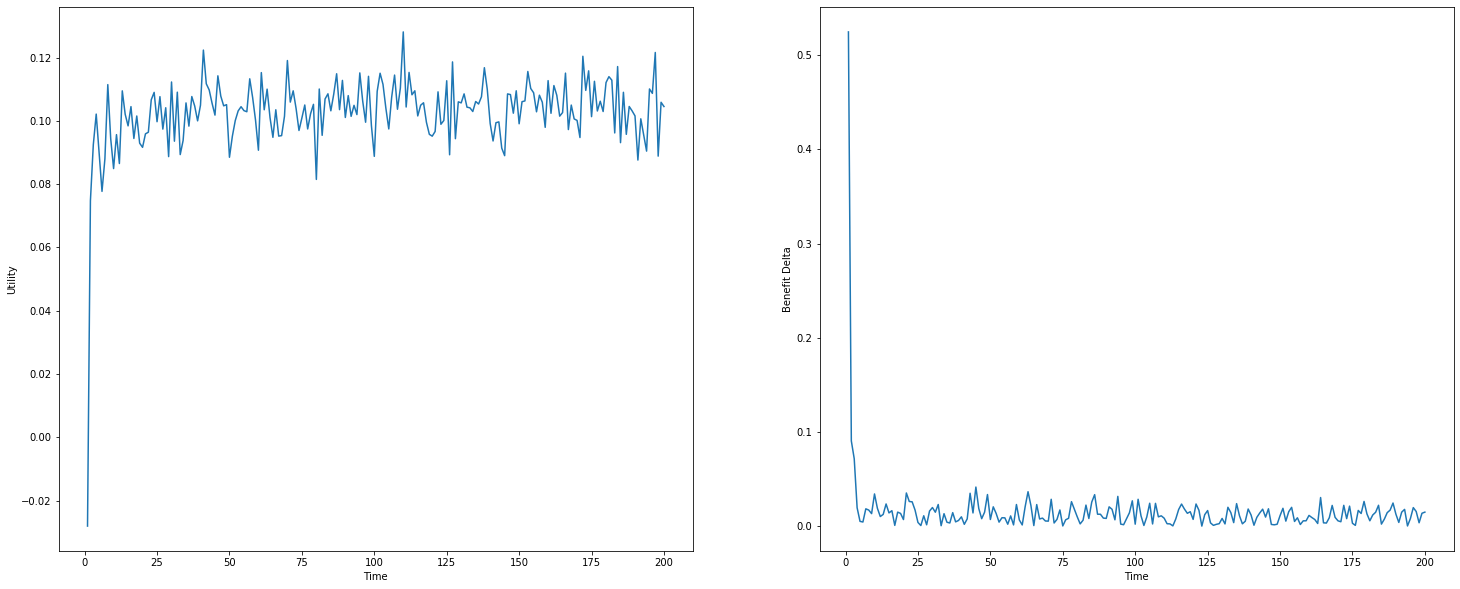

In [31]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(25,10))
ax1.plot(range(1, len(utilities) + 1), utilities)
ax1.set_xlabel("Time")
ax1.set_ylabel("Utility")
ax2.plot(range(1, len(benefit_deltas) + 1), benefit_deltas)
ax2.set_xlabel("Time")
ax2.set_ylabel("Benefit Delta")
plt.show()